<a href="https://colab.research.google.com/github/skbansal5642/Flight_time_prediction/blob/master/On-Time%20Flight%20Arrivals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Import data into a notebook using curl
    Use Pandas to clean and prepare data
    Use scikit-learn to build a machine-learning model
    Use Matplotlib to visualize the results

### download the csv file from given url (work in bash shell)

In [1]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0  2345k      0 --:--:-- --:--:-- --:--:-- 2342k


### load data and create a DataFrame & display 5 rows

In [2]:
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,14747,SEA,1905,1907.0,2.0,0.0,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,13487,MSP,1345,1344.0,-1.0,0.0,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,14747,SEA,940,942.0,2.0,0.0,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,13487,MSP,819,820.0,1.0,0.0,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,11433,DTW,2300,2256.0,-4.0,0.0,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [3]:
# shows total no. of rows and columns
df.shape

(11231, 26)

In [4]:
# check whether any value is missing in dataset
df.isnull().values.any()

True

In [5]:
# find out where the missing values are
df.isnull().sum()
# shows no. of missing values in each column

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [6]:
# as we see column (Unnamed: 25) has all rows NULL
# It was created as dataset is in comma form
# now, eleminate that column
df = df.drop('Unnamed: 25', axis=1)
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [7]:
# now we have to filter out the columns that we don't need
# we will select the columns on which our prediction is highly dependent
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [8]:
# show the first 5 missing values in ARR_DEL15 Column
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


In [9]:
# these values are missing if flights 
# have been cancelled or diverted to another airport.
# These can be considered as late
# We can use fun. "dropna" to remove these rows
# but we use "fillna" to replace these NaN by '1'
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


In [10]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,1905,0.0
1,1,1,5,DTW,MSP,1345,0.0
2,1,1,5,ATL,SEA,940,0.0
3,1,1,5,SEA,MSP,819,0.0
4,1,1,5,SEA,DTW,2300,0.0


In [11]:
# now bin (quatized) the departure time
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


In [12]:
# generate indicator column from ORIGIN & DEST column
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


In [13]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

In [14]:
train_x.shape

(8984, 14)

In [15]:
test_x.shape

(2247, 14)

Training the Model

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

Testing the Model

In [17]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8642634623943035

Generating AUC score

In [18]:
'''There are several ways to measure the accuracy of a classification model.
   One of the best overall measures for a binary classification model is
   Area Under Receiver Operating Characteristic Curve (ROC AUC), 
   which essentially quantifies
   how often the model will make a correct prediction regardless of the outcome
'''
# First we will generate a set prediction probabilities
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [19]:
# Calculate ROC AUC score using scikit-learn's method roc_auc_score
roc_auc_score(test_y, probabilities[:, 1])

0.7014819895830565

In [20]:
'''
You can learn more about the model's behavior
by generating a confusion matrix or an error matrix.
The confusion matrix quantifies the number of times each answer was classified correctly or incorrectly.
Specifically, it quantifies the number of false positives, false negatives, true positives, and true negatives
'''
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1903,   33],
       [ 272,   39]])

Measuring precision

In [21]:
# there is other measure of accuracy for a clissification model
# i.e., precision and recall
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

1.0

Measuring recall

In [22]:
from sklearn.metrics import recall_score
recall_score(train_y, train_predictions)

0.9992012779552716

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Plot the ROC curve using matplotlib

Text(0, 0.5, 'True Positive Rate')

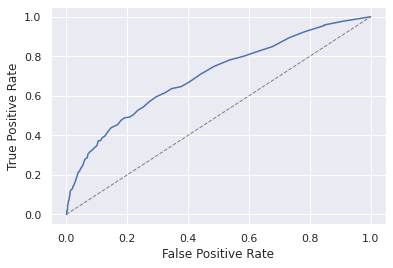

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Create a function using the model created earlier
to determine whether the flight will be on-time or not

In [25]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

Predicting whether a flight will be on-time
    # e.g.
    compute the probability that a flight from New York to Atlanta on the evening of October 1 will arrive on time

In [26]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.88

flight the same day from Atlanta to Seattle will arrive on time

In [27]:
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

0.99

Probability of on-time arrivals for a range of dates

(0.0, 1.0)

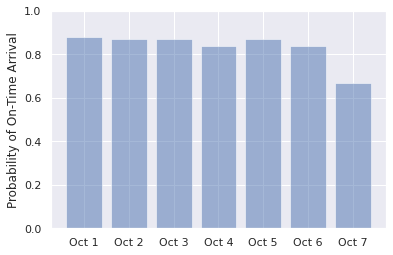

In [28]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

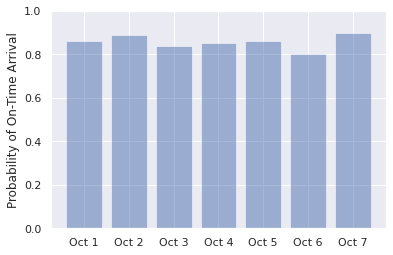

In [29]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('10/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('11/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('12/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('13/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('14/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('15/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('16/4/2018 13:00:00', 'JFK', 'MSP'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

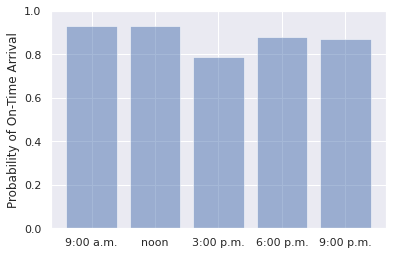

In [30]:
import numpy as np

labels = ('9:00 a.m.', 'noon', '3:00 p.m.', '6:00 p.m.', '9:00 p.m.')
values = (predict_delay('30/1/2018 9:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 12:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 15:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 18:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 21:00:00', 'SEA', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))